In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
# imports
import pprint
import pickle
import glob
import random
from pathlib import Path
import math

import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from utils import general_utils
from utils import eval_utils
import deformation.losses as def_losses

In [17]:
def get_combined_cached_poses(refined_models_dir):
    # combining all cached predicted poses
    pred_poses_dict = {}
    pred_pose_paths = list(Path(refined_models_dir).rglob('pred_poses.p'))
    for pred_pose_path in pred_pose_paths:
        curr_cache = pickle.load(open(pred_pose_path, "rb"))
        pred_poses_dict = {**pred_poses_dict, **curr_cache}
    return pred_poses_dict

# TODO: double check this
# https://pytorch3d.readthedocs.io/en/latest/_modules/pytorch3d/renderer/cameras.html#camera_position_from_spherical_angles
def spherical_to_cart(dist, elev, azim):
    x = dist * np.cos(elev) * np.sin(azim)
    y = dist * np.sin(elev)
    z = dist * np.cos(elev) * np.cos(azim)
    return np.array([x,y,z])

In [51]:
refinement_dir = "data/refinements/shapenet_occnet_refinements"
#class_ids = ["02691156", "02828884", "02933112", "02958343", "03001627", "03211117", "03636649", "03691459", "04090263", "04256520", "04379243", "04401088", "04530566"]
class_ids = ["02828884"]

gt_pose_refinement_dir = os.path.join(refinement_dir, "gt_pose")
bf_pose_refinement_dir = os.path.join(refinement_dir, "bf_pose")

In [52]:
correlation_df = pd.DataFrame()
from scipy.spatial import distance
for class_id in class_ids:
    bf_class_dir = os.path.join(refinement_dir, "bf_pose", class_id)
    gt_class_dir = os.path.join(refinement_dir, "gt_pose", class_id)
    class_bf_poses = get_combined_cached_poses(bf_class_dir)
    class_gt_poses = get_combined_cached_poses(gt_class_dir)
    bf_eval_results = pd.read_pickle(os.path.join(bf_class_dir, "eval_results.pkl"))
    gt_eval_results = pd.read_pickle(os.path.join(gt_class_dir, "eval_results.pkl"))
    
    for instance in class_bf_poses:
        if instance in class_gt_poses:
            bf_cam_loc = spherical_to_cart(class_bf_poses[instance]["dist"],class_bf_poses[instance]["elev"],class_bf_poses[instance]["azim"])
            gt_cam_loc = spherical_to_cart(class_gt_poses[instance]["dist"],class_gt_poses[instance]["elev"],class_gt_poses[instance]["azim"])
            # TODO: deal with symmetry?
            pose_dist = distance.cosine(bf_cam_loc,gt_cam_loc)
            #pose_dist = np.linalg.norm(bf_cam_loc - gt_cam_loc)
            
            bf_3d_iou = (bf_eval_results[bf_eval_results["instance"] == instance])["3d_iou"].item()
            gt_3d_iou = (gt_eval_results[gt_eval_results["instance"] == instance])["3d_iou"].item()
            iou_delta = gt_3d_iou - bf_3d_iou
            correlation_entry = {"class":class_id, "instance":instance, "pose_dist":pose_dist, "iou_delta":iou_delta}
            correlation_df = correlation_df.append(correlation_entry, ignore_index=True)
    
    
    break

,class,instance,iou_delta,pose_dist
0,02828884,c83b3192c338527a2056b4bd5d870b47,0.046524,1.289440
1,02828884,c8802eaffc7e595b2dc11eeca04f912e,0.167989,1.716207
2,02828884,c89d4c95f1e7c950a805114916841d69,-0.032872,0.718357
3,02828884,c8a2ce0e65da4b817b11ae648ea92233,0.094832,1.017053
4,02828884,c8fa692760ba875848d791284650e46d,0.049864,1.533144
...,...,...,...,...
347,02828884,ff5c5895622d2123aa979e53c1a67c26,0.361358,0.994793
348,02828884,ff71a0d33a3aa440565888a91a05d618,0.013550,1.508063
349,02828884,ff7a08ac16701dcec0277fc71766d822,0.118345,0.922915
350,02828884,ff8f8d280de66226d2b12aa6a0f050b3,-0.077217,0.061279


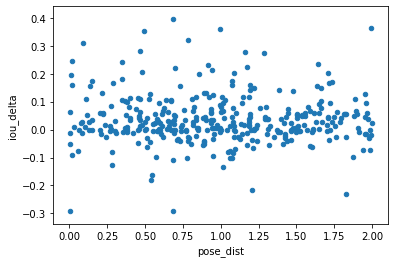

In [53]:
display(correlation_df)
correlation_df.plot.scatter("pose_dist", "iou_delta")